In [12]:
# 1.0 Loading and Splitting Data
import pandas as pd
import os
from sklearn.model_selection import train_test_split
import tensorflow as tf
from PIL import Image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
import keras as keras

# EfficientNetB0 Model
from tensorflow.keras.applications import EfficientNetB0
from keras.callbacks import EarlyStopping
from keras.callbacks import ReduceLROnPlateau
from keras.models import Sequential
from keras.layers import Dense, Dropout, GlobalAveragePooling2D

# ResNet50
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam


In [16]:
# Load the dataset
csv_path = "data/sports.csv"
df = pd.read_csv(csv_path)

# Add full file paths to the dataframe
df['filepaths'] = df['filepaths'].apply(lambda x: os.path.join("data", x))

# Split the dataset into train and validation sets
train_df = df[df['data set'] == 'train']
valid_df = df[df['data set'] == 'valid']
test_df = df[df['data set'] == 'test']

train_df.shape, valid_df.shape, test_df.shape

((13493, 4), (500, 4), (500, 4))

In [17]:
print(train_df.columns)
# Check the first few file paths
print(train_df['filepaths'].head())

# Verify if the files exist
import os
missing_files = train_df[~train_df['filepaths'].apply(os.path.exists)]
print(f"Missing files: {len(missing_files)}")
if not missing_files.empty:
    print(missing_files)

Index(['class id', 'filepaths', 'labels', 'data set'], dtype='object')
0    data/train/air hockey/001.jpg
1    data/train/air hockey/002.jpg
2    data/train/air hockey/003.jpg
3    data/train/air hockey/004.jpg
4    data/train/air hockey/005.jpg
Name: filepaths, dtype: object
Missing files: 0


In [28]:

# 2.0 Data Augmentation and Preprocessing
# Define data generators

train_datagen = ImageDataGenerator(
        rescale=1.0/255.0,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True)

valid_datagen = ImageDataGenerator()

# Create data generators
train_generator = train_datagen.flow_from_dataframe(
    train_df,
    x_col='filepaths',
    y_col='labels',
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical'
)

valid_generator = valid_datagen.flow_from_dataframe(
    valid_df,
    x_col='filepaths',
    y_col='labels',
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical'
)


Found 13492 validated image filenames belonging to 100 classes.
Found 500 validated image filenames belonging to 100 classes.


/opt/anaconda3/lib/python3.12/site-packages/keras/src/legacy/preprocessing/image.py:920: UserWarning: Found 1 invalid image filename(s) in x_col="filepaths". These filename(s) will be ignored.
  warnings.warn(


In [25]:
# Check the first few file paths
print(train_df['filepaths'].head())

# Verify if the files exist
import os
missing_files = train_df[~train_df['filepaths'].apply(os.path.exists)]
print(f"Missing files: {len(missing_files)}")
if not missing_files.empty:
    print(missing_files)
    

0    data/train/air hockey/001.jpg
1    data/train/air hockey/002.jpg
2    data/train/air hockey/003.jpg
3    data/train/air hockey/004.jpg
4    data/train/air hockey/005.jpg
Name: filepaths, dtype: object
Missing files: 0


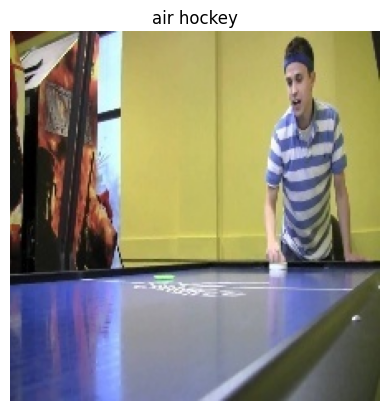

In [26]:
# Load and display the first image
image_path = train_df['filepaths'].iloc[0]
try:
    image = Image.open(image_path)
    plt.imshow(image)
    plt.axis('off')
    plt.title(train_df['labels'].iloc[0])
    plt.show()
except FileNotFoundError:
    print(f"File not found: {image_path}")

Shape of X_batch (images): (32, 224, 224, 3)
Shape of y_batch (labels): (32, 100)
[[[0.0496945  0.0496945  0.04185136]
  [0.04492487 0.04492487 0.0375109 ]
  [0.04325401 0.04325401 0.03923639]
  ...
  [0.04513945 0.0489782  0.04705883]
  [0.04545787 0.04929662 0.04737724]
  [0.04694362 0.05056147 0.04875254]]

 [[0.04909403 0.04909403 0.04125089]
  [0.0473498  0.0473498  0.03950666]
  [0.0497196  0.0497196  0.04187646]
  ...
  [0.04705883 0.04705883 0.04705883]
  [0.04705883 0.04705883 0.04705883]
  [0.04683805 0.04683805 0.04683805]]

 [[0.04755153 0.04755153 0.03970839]
  [0.04784731 0.04784731 0.04000417]
  [0.05428658 0.05428658 0.04644344]
  ...
  [0.04705883 0.04705883 0.04705883]
  [0.04705883 0.04705883 0.04705883]
  [0.04680827 0.04680827 0.04680827]]

 ...

 [[0.6240568  0.02485578 0.3802431 ]
  [0.7007103  0.1151848  0.46592662]
  [0.6797078  0.15542175 0.49185205]
  ...
  [0.55726475 0.5089458  0.45720023]
  [0.4747215  0.42640308 0.36766422]
  [0.32428214 0.27596378 0.2163

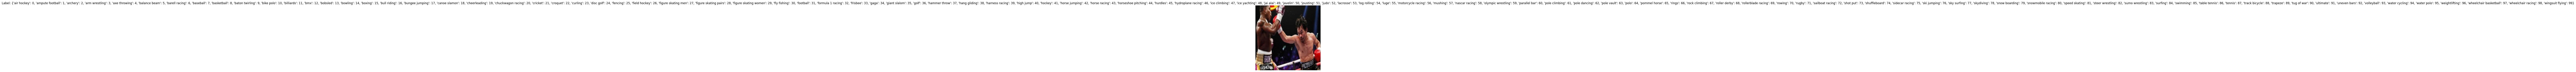

In [29]:
# Fetch one batch of data
X_batch, y_batch = next(train_generator)

# Check the shape of the batch
print("Shape of X_batch (images):", X_batch.shape)
print("Shape of y_batch (labels):", y_batch.shape)

# Display the first image in the batch
print(X_batch[0])
plt.imshow(X_batch[0])
plt.axis('off')
plt.title(f"Label: {train_generator.class_indices}")
plt.show()

In [ ]:
# 3.0 Model Creation and Training

# Load ResNet50 as the base model
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Freeze the base model layers
base_model.trainable = True

for layer in base_model.layers[:100]:  # Freeze the first 100 layers
    layer.trainable = False

# Add custom layers on top of the base model
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dropout(0.5)(x)
x = Dense(256, activation='relu')(x)
x = Dropout(0.5)(x)
# Calculate the number of unique classes from the training dataframe
num_classes = train_df['labels'].nunique()
predictions = Dense(num_classes, activation='softmax')(x)

# Create the model
model = Model(inputs=base_model.input, outputs=predictions)

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

# Train the model
history = model.fit(
    train_generator,
    validation_data=valid_generator,
    epochs=5,
    steps_per_epoch=train_generator.samples // train_generator.batch_size,
    validation_steps=valid_generator.samples // valid_generator.batch_size
)

Epoch 1/5
  9/421 ━━━━━━━━━━━━━━━━━━━━ 23:33 3s/step - accuracy: 0.0054 - loss: 5.0416

KeyboardInterrupt: 

In [7]:
# Finetune the model

# Unfreeze some layers of the base model
base_model.trainable = True
for layer in base_model.layers[:100]:  # Freeze the first 100 layers
    layer.trainable = False

# Recompile the model with a lower learning rate
model.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

# Fine-tune the model
history_fine = model.fit(
    train_generator,
    validation_data=valid_generator,
    epochs=5,
    steps_per_epoch=train_generator.samples // train_generator.batch_size,
    validation_steps=valid_generator.samples // valid_generator.batch_size
)

Epoch 1/5
421/421 ━━━━━━━━━━━━━━━━━━━━ 1431s 3s/step - accuracy: 0.0103 - loss: 4.6672 - val_accuracy: 0.0125 - val_loss: 4.5661
Epoch 2/5
  1/421 ━━━━━━━━━━━━━━━━━━━━ 22:23 3s/step - accuracy: 0.0312 - loss: 4.5658

/opt/anaconda3/lib/python3.12/site-packages/keras/src/trainers/epoch_iterator.py:107: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


421/421 ━━━━━━━━━━━━━━━━━━━━ 24s 49ms/step - accuracy: 0.0312 - loss: 4.5658 - val_accuracy: 0.0125 - val_loss: 4.5671
Epoch 3/5
421/421 ━━━━━━━━━━━━━━━━━━━━ 1375s 3s/step - accuracy: 0.0181 - loss: 4.5817 - val_accuracy: 0.0292 - val_loss: 4.4322
Epoch 4/5
421/421 ━━━━━━━━━━━━━━━━━━━━ 24s 50ms/step - accuracy: 0.0312 - loss: 4.4663 - val_accuracy: 0.0354 - val_loss: 4.4364
Epoch 5/5
319/421 ━━━━━━━━━━━━━━━━━━━━ 5:30 3s/step - accuracy: 0.0252 - loss: 4.5018

KeyboardInterrupt: 

In [ ]:
# EfficientNetB0 Model

# Define callbacks

early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=3, min_lr=1e-7)

# Load ResNet50 as the base model
base_model = EfficientNetB0(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
# Freeze the base model layers
base_model.trainable = True
for layer in base_model.layers[:100]:  # Freeze the first 100 layers
    layer.trainable = False
# Add custom layers on top of the base model

# Create a new model
model = Sequential()

# Add the pre-trained VGG16 base model
model.add(base_model)
model.add(GlobalAveragePooling2D())
# Add a dense layer with 256 neurons and ReLU activation
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.25))

# Add a dense layer with the number of output classes and softmax activation
model.add(Dense(100, activation='softmax'))

model.compile(optimizer='adam',loss='categorical_crossentropy'
                 ,metrics=['accuracy','Precision','Recall'])

history2 = model.fit(
        train_generator,
        validation_data=valid_generator,
        epochs=10,
        callbacks=[early_stopping, reduce_lr])

/opt/anaconda3/lib/python3.12/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
413/422 ━━━━━━━━━━━━━━━━━━━━ 22s 3s/step - Precision: 0.2493 - Recall: 0.0018 - accuracy: 0.0409 - loss: 4.3899

KeyboardInterrupt: 